In [2]:
import sys; sys.path.append('../../rxrx1-utils/')
import rxrx
import rxrx.io as rio  # Doesn't work

2024-10-19 00:05:09.533231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729296310.759316    3630 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729296311.106415    3630 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 00:05:15.132531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Visualize the 6 channels of a single EGFR KOs

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Using the RGB_MAP from rxrx code
RGB_MAP = {
    1: {
        'rgb': np.array([19, 0, 249]),
        'range': [0, 51]
    },
    2: {
        'rgb': np.array([42, 255, 31]),
        'range': [0, 107]
    },
    3: {
        'rgb': np.array([255, 0, 25]),
        'range': [0, 64]
    },
    4: {
        'rgb': np.array([45, 255, 252]),
        'range': [0, 191]
    },
    5: {
        'rgb': np.array([250, 0, 253]),
        'range': [0, 89]
    },
    6: {
        'rgb': np.array([254, 255, 40]),
        'range': [0, 191]
    }
}

def load_image(image_path):
    """Load a single channel image."""
    return np.array(Image.open(image_path))

def normalize_to_8bit(image):
    """Normalize a 32-bit image to 8-bit."""
    image_8bit = np.array(image, dtype=np.float32)
    image_8bit = (image_8bit - image_8bit.min()) / (image_8bit.max() - image_8bit.min()) * 255
    return image_8bit.astype(np.uint8)

def convert_tensor_to_rgb(t, channels=[1, 2, 3, 4, 5, 6], vmax=255, rgb_map=RGB_MAP):
    """Converts and returns the image data as RGB image, following rxrx approach."""
    colored_channels = []
    for i, channel in enumerate(channels):
        x = (t[:, :, i] / vmax) / \
            ((rgb_map[channel]['range'][1] - rgb_map[channel]['range'][0]) / 255) + \
            rgb_map[channel]['range'][0] / 255
        x = np.where(x > 1., 1., x)
        x_rgb = np.array(
            np.outer(x, rgb_map[channel]['rgb']).reshape(t.shape[0], t.shape[1], 3),
            dtype=int)
        colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    return im

def visualize_rgb_from_rxrx_with_normalized(image_files):
    """Visualize the composite image using rxrx logic."""
    normalized_images = [normalize_to_8bit(Image.open(image_file)) for image_file in image_files]
    tensor = np.stack(normalized_images, axis=-1)  # Stack the 6 channels into a tensor
    rgb_image = convert_tensor_to_rgb(tensor)      # Use the rxrx-style conversion
    plt.imshow(rgb_image)
    plt.title('RGB Composite Image with Normalized Channels')
    plt.axis('off')
    plt.show()

# load and normalize the image (same as before)
def load_image(image_path):
    return np.array(Image.open(image_path))

def normalize_to_8bit(image):
    image_8bit = np.array(image, dtype=np.float32)
    image_8bit = (image_8bit - image_8bit.min()) / (image_8bit.max() - image_8bit.min()) * 255
    return image_8bit.astype(np.uint8)

def plot_3x2_channels(image_files):
    """Plots 6 image channels in a 3x2 layout."""
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))  # 3x2 grid
    axes = axes.ravel()  # Flatten the axes array

    for i, image_file in enumerate(image_files):
        img = normalize_to_8bit(Image.open(image_file))  # load and normalize
        axes[i].imshow(img, cmap='gray')  # display the image in grayscale
        axes[i].set_title(f'Channel {i+1}')
        axes[i].axis('off')  # hide axis for clean visualization

    plt.tight_layout()
    plt.show()

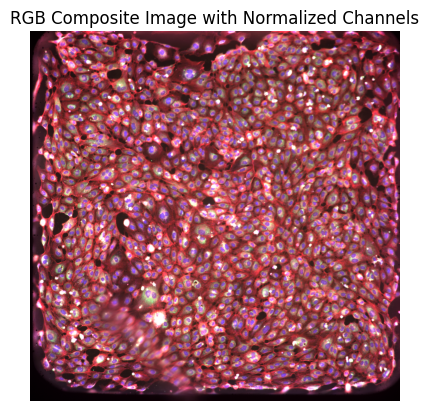

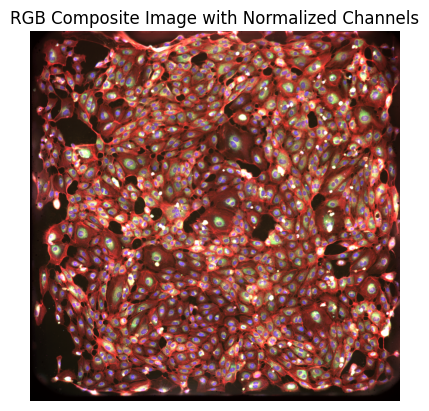

In [5]:
# Paths to the uploaded files
ADDRESS = 'AA30'

def get_image_files_for_address(image_dir, address):
    image_files = [
        f'{image_dir}/{address}_s1_w1.png',  # replace with actual paths to the images
        f'{image_dir}/{address}_s1_w2.png',
        f'{image_dir}/{address}_s1_w3.png',
        f'{image_dir}/{address}_s1_w4.png',
        f'{image_dir}/{address}_s1_w5.png',
        f'{image_dir}/{address}_s1_w6.png'
    ]
    return image_files

# Run the visualization
visualize_rgb_from_rxrx_with_normalized(get_image_files_for_address(image_dir='egfr-images/ko/gene-081_EGFR', address='AA16'))
visualize_rgb_from_rxrx_with_normalized(get_image_files_for_address(image_dir='egfr-images/ko/gene-081_EGFR', address='AA30'))
# visualize_rgb_from_rxrx_with_normalized(get_image_files_for_address(image_dir='gene-081_EMPTY_control', address='AA03'))

In [ ]:
plot_3x2_channels(image_dir='gene-081_EGFR', address='AA16'))

In [31]:
def save_composite_image(image_files, save_path):
    """Create and save the composite RGB image."""
    # Load and normalize images
    normalized_images = [normalize_to_8bit(Image.open(image_file)) for image_file in image_files]
    
    # Create the composite image
    tensor = np.stack(normalized_images, axis=-1)
    rgb_composite = convert_tensor_to_rgb(tensor)
    
    # Ensure the composite image is in uint8 format
    rgb_composite_uint8 = np.clip(rgb_composite, 0, 255).astype(np.uint8)
    
    # Save the composite image directly
    plt.imsave(save_path, rgb_composite_uint8)

save_composite_image(get_image_files_for_address(image_dir='gene-081_EMPTY_control', address='AA03'), save_path='AA03-composite.png')